5/29/24:
TODO:
1. Add in dissipation term to fully generalize this in 1D
2. Work specific problems.
3. Once solid, sart adding dimensions

# General Burgers: $u_{t} + (u)u_{x} - \alpha u_{xx} = 0$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

Interactive 3D potter (ensure %matplotlib widget in library calls)

In [2]:
def PDE_plotter_3D(x_grid, t_grid, U):
    %matplotlib widget
    x,t = np.meshgrid(x_grid, t_grid)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, t, U, cmap='viridis')
    ax.set_xlabel('Space (r)')
    ax.set_ylabel('Time (t)')
    ax.set_zlabel('u(r,t)')
    plt.show()

## I. Inviscid Burgers, using Godunov's Scheme (From Libraries): $u_{t} + (u)u_{x} = 0$

In [3]:
# Load code libraries
from godunov_burgers import PDE_plotter_1D as Pplot
from godunov_burgers import second_order_godunov_burgers as gb

1. Define Boundary Conditions

In [4]:
# Boundary Condition Functions (Direchelet - time domain)

def u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''
    return t

def u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return t

# Initial Condition Functions

def u_0_x(x):
    '''
    Assigns the initial values for u (non-boundary points).
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return np.sin(np.pi*2*x)

In [5]:
# Determing the FLRW acceleration term
def a(t):
    '''
    Using the standard a(t) = t/t0^(2/3) for matter dominated universe
    '''
    
    return 1 + t**(2/3)

2. Create the grid

In [6]:
# Create Grid and initiatlize - these will represent Cells rather than nodes
L = 1
t_max = 1

dx = .01
dt = .0001

3. Run the Function

In [7]:
k = 0
#second_order_godunov_burgers(u_0_x, u_t_0, u_t_L, a_t, dx, dt, t_max, L, k)
u = gb(u_0_x, u_t_0, u_t_L, a, dx, dt, t_max, L, k)

4. Plot the function

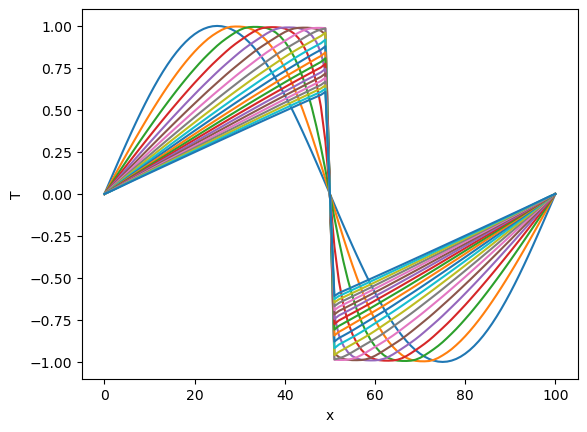

In [8]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(u),500):
    plt.plot(u[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

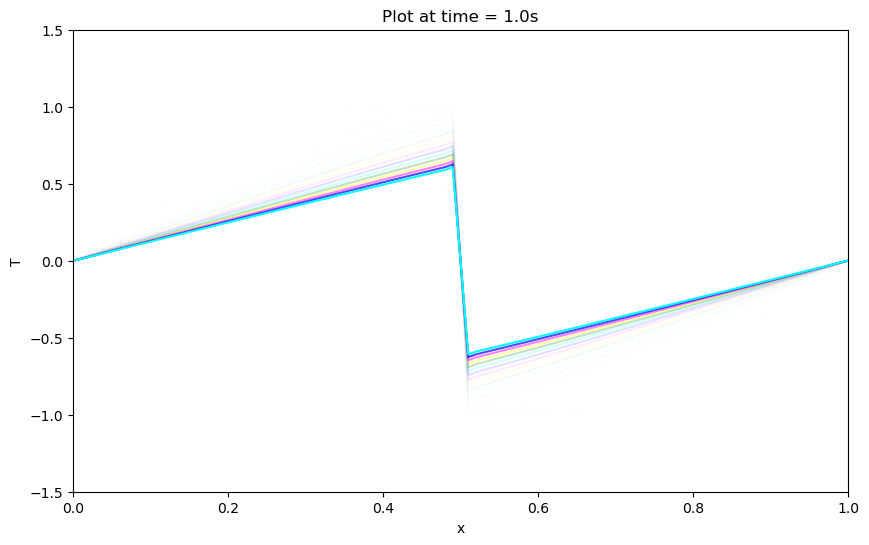

In [9]:
steps = 20
t_min_plot = 0             # default = 0
t_max_plot = t_max      # default = len(U)
x_min_plot = 0           # default = 0
x_max_plot = L         # default = L

Pplot(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot)

## II. Inviscid Burgers using Explicit Method 
### (Original Method, shows shockwave oscillations)

1. Create grid and initialize.

In [10]:
# Create Grid
L = 1
t_max = .25

dx = .01
dt = .0001

Nx = int(L/dx) + 1
Nt = int(t_max/dt) + 1

x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

# Initialize Array with initial conditions
U = []

u_t_x_0 = []

for x in x_grid:
    u_t_x_0.append(u_0_x(x))
U.append(u_t_x_0)

2. Run the explicit algorithm.

In [11]:
for i in range(Nt):
    u_t_x = []
    
    u_line = U[-1]
    
    for j in range(1,Nx-1):
        # Using a time-forward centered difference formula (TFCD) 
        u = u_line[j] - ((dt/(2*dx)) * u_line[j] * (u_line[j+1] - u_line[j-1]))
        # Append this value to the time step line
        u_t_x.append(u)

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,0)
    u_t_x.insert(len(u_line),0)

    # Now append the full solutions matrix
    U.append(u_t_x) 
    
#Convert to np array
U = np.array(U)

3. Basic Plot

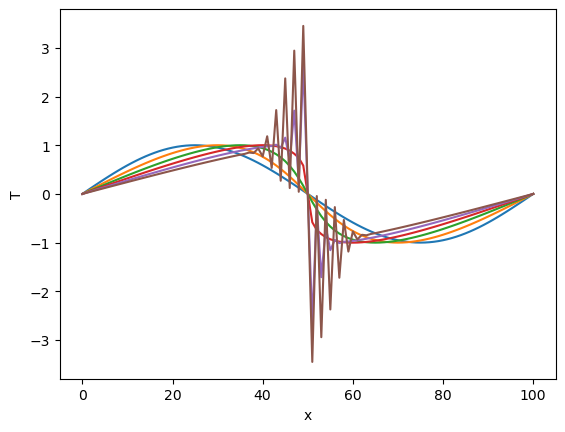

In [12]:
# Plotting t = 0 to t = 1000, in 20dt increments
for i in np.arange(0,len(U),500):
    plt.plot(U[i])
    plt.xlabel('x')
    plt.ylabel('T')
plt.show()

4. Advanced Plot

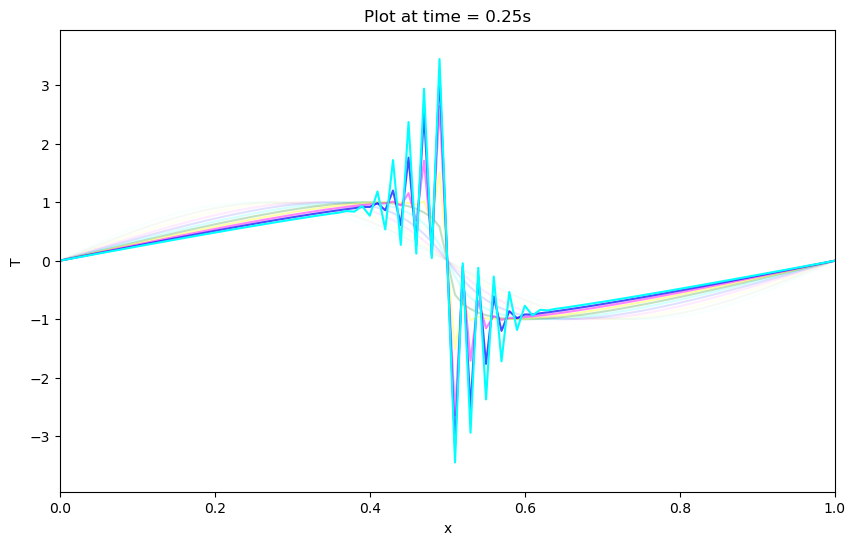

In [13]:
Pplot(U, L, t_max, 10, 0,t_max,0, L)

Shocks (and then blowup) develop at x = .5 and around t = .18s.  Zooming in:

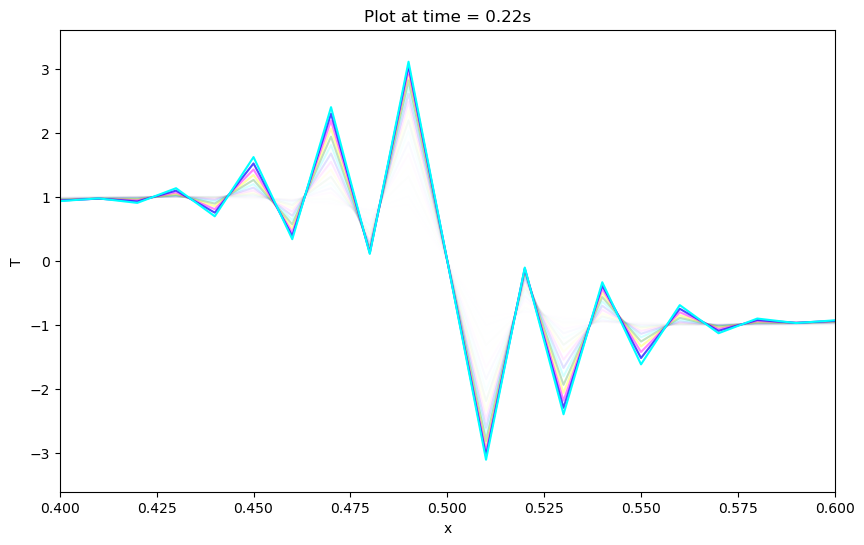

In [14]:
steps = 20
t_min_plot = .15             # default = 0
t_max_plot = .22      # default = len(U)
x_min_plot = .4            # default = 0
x_max_plot = .6          # default = L

Pplot(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot)

5. 3D plot

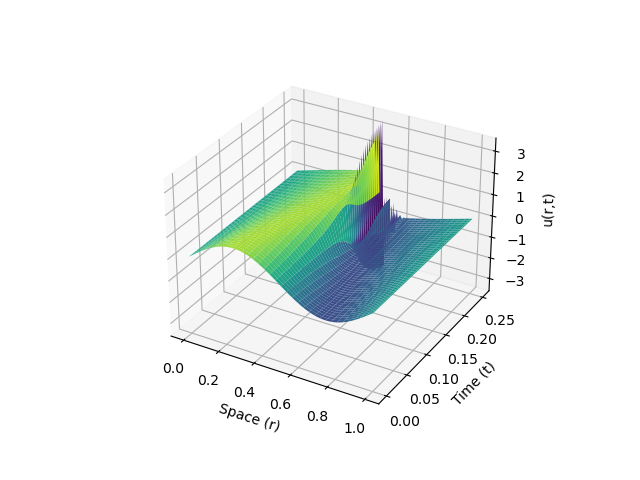

In [15]:
PDE_plotter_3D(x_grid, t_grid, U[:-1])

## III. Gudonov Scheme Approach (Used to build functions in Part 1)
This is a finite volume scheme preferred for the Inviscid Burgers.  Note that Implicit Schemes not recommended for hyperbolic functions.

In [26]:
# Create Grid and initiatlize - these will represent Cells rather than nodes
L = 1
t_max = 3

dx = .01
dt = .0001

In [24]:
# Determing the FLRW acceleration term
def a(t):
    '''
    Using the standard a(t) = t/t0^(2/3) for matter dominated universe
    '''
    
    return -t + (1/3)*t**3

In [18]:
def godunov_flux(ul, ur, a):
    """Godunov's flux for the inviscid Burgers' equation with scale factor"""
    if ul > ur:
        if ul > 0 and ur > 0:
            return 0.5 * ul**2 / a
        elif ul < 0 and ur < 0:
            return 0.5 * ur**2 / a
        else:
            return 0
    else:
        if ul + ur > 0:
            return 0.5 * ul**2 / a
        else:
            return 0.5 * ur**2 / a

In [19]:
def minmod(a, b):
    '''
    Minmod function for slope limiting - improves Gudanov's w/ MUSCL - Monotonic Upstream Centered Schemes for Conservation Laws
    '''
    if a * b <= 0:
        return 0
    else:
        return min(abs(a), abs(b)) * np.sign(a)

In [20]:
def second_order_godunov_burgers(u_0_x, u_t_0, u_t_L, dx, dt, t_max, L, k):
    '''
    
    '''
    Nx = int(L/dx) + 1
    Nt = int(t_max/dt) + 1

    x_grid = np.linspace(0,L,Nx)
    t_grid = np.linspace(0,t_max,Nt)
    
    u_0 = u_0_x(x_grid)
    
    nt = int(t_max / dt)
    nx = len(u_0)
    u = np.zeros((nt + 1, nx))
    u[0, :] = u_0

    for n in range(nt):
        t = n * dt
        at = a(t)
        u_n = u[n, :]
        uL = np.zeros(nx - 1)
        uR = np.zeros(nx - 1)
        flux = np.zeros(nx)

        for i in range(1, nx - 1):
            duL = minmod(u_n[i] - u_n[i - 1], u_n[i + 1] - u_n[i])
            duR = minmod(u_n[i + 1] - u_n[i], u_n[i + 2] - u_n[i + 1] if i + 2 < nx else 0)

            uL[i] = u_n[i] + 0.5 * duL
            uR[i] = u_n[i + 1] - 0.5 * duR

        for i in range(1, nx - 1):
            flux[i] = godunov_flux(uL[i], uR[i], at)

        for i in range(1, nx - 1):
            u[n + 1, i] = u_n[i] - dt / dx * (flux[i] - flux[i - 1]) - dt * k * u_n[i] / at**2
        
        # Boundary conditions
        u[n + 1, 0] = u_t_0(0)
        u[n + 1, -1] = u_t_L(0)

    return u

t_min_index: 0
t_max_index: 30002
x_min_index: 0
x_max_index: 101


ValueError: Axis limits cannot be NaN or Inf

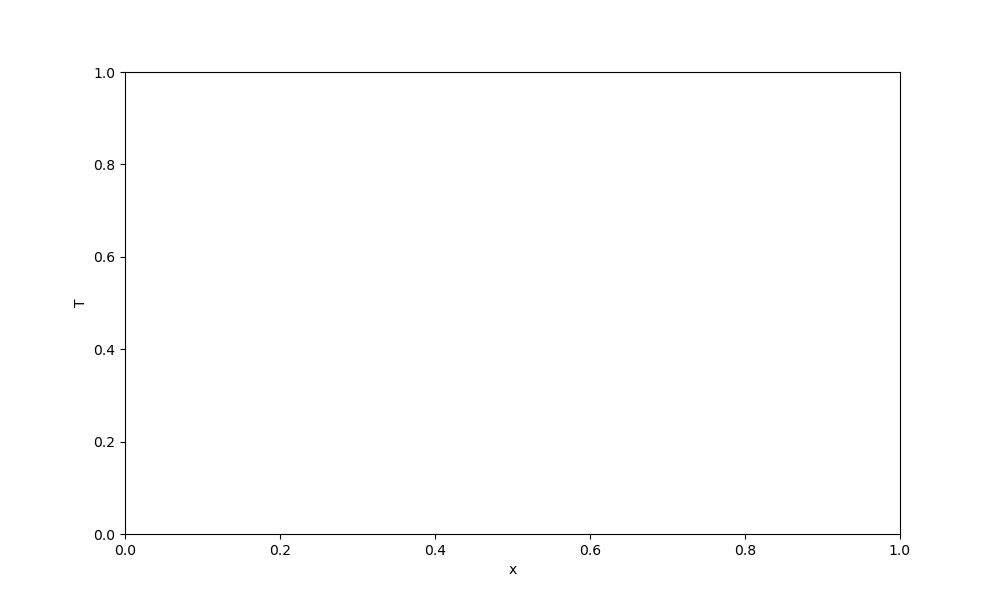

In [27]:
k = 1
u = gb(u_0_x, u_t_0, u_t_L, a, dx, dt, t_max, L, k)

steps = 20
t_min_plot = 0             # default = 0
t_max_plot = t_max      # default = len(U)
x_min_plot = 0           # default = 0
x_max_plot = L         # default = L

Pplot(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot)

In [ ]:
PDE_plotter_3D(x_grid, t_grid, u)